To validate the significance of the 10 obtained genes that separate best the Sen, NSen and Basal cell types, we are conducting the following randomization validation.

1. The dataframe consisting of the 142 genes (obtained after the filtering process described in notebook 1) is
2. Those 1000 randomly labeled datasets are submitted to the ECFS algorithm to obtain the gene ranking.
3. The Newtork-Community analysis is computed for the each of the ranking and the h-value for the top 10 genes is obtained.
4. Since this is done 1000x, we have 1000 values for the h-parameter, each corresponding to one of the randomly labeled datasets.
5. The significance of our selected h-value (0.737) is tested by comparing it to the distribution of the 1000 h-values obtained from the randomly labeled datasets.

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.algorithms import community
import community
import matplotlib
import itertools
import random
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df_filtered = pd.read_csv("df_filteredKS.csv", sep="\t")
df_filtered

geneID    G7F_mean  G7FNSen_mean  G7FSen_mean   G7M_mean  \
0    ENSMUSG00000026154    9.374707     12.772968    27.824232   5.671751   
1    ENSMUSG00000101372    1.444587      1.111497     0.371584   0.699926   
2    ENSMUSG00000026087   22.069027     25.173005    43.724768  16.839861   
3    ENSMUSG00000041763   18.230442     11.950132    12.110390  28.941241   
4    ENSMUSG00000025982  112.095088     84.476640    55.605328  83.438708   
..                  ...         ...           ...          ...        ...   
137  ENSMUSG00000031385    0.000000      0.367214     0.398137   0.000000   
138  ENSMUSG00000002014   36.531070     61.966370    94.802257  64.016520   
139  ENSMUSG00000031198   22.257823     26.709863    36.829580  13.182433   
140  ENSMUSG00000025525    1.787333      2.887403     7.121444   3.833947   
141  ENSMUSG00000025289   64.794850    122.431833   114.343833  50.193153   

     G7MNSen_mean  G7MSen_mean    G7S_mean  G7SNSen_mean  G7SSen_mean  ...  \
0       11.260086    16.675180    0.000000      6.299948    16.657781  ...   
1        0.330705     0.364940    1.624852      0.486327     0.348787  ...   
2       20.386269    26.003121   20.099141     31.424203    30.086606  ...   
3       17.719509    14.524426   27.617458     16.755259    17.023425  ...   
4       65.120788    51.364688  120.530328     74.634990    59.653100  ...   
..            ...          ...         ...           ...          ...  ...   
137      0.000000     0.068053    0.000000      0.000000     1.463048  ...   
138     57.620877    83.569053   31.541450     29.319517    29.808617  ...   
139     13.808850    21.667137    8.334765     25.366677    35.125597  ...   
140      3.837358     8.342085    3.408360      8.749270    17.766763  ...   
141     44.132810    48.840410   23.275993     53.697473    72.309847  ...   

     G3SSen_mean   Y3F_mean  Y3FNSen_mean  Y3FSen_mean   Y3M_mean  \
0      45.174186  21.242280     26.628339    33.862152  21.526737   
1       0.114060   0.582884      0.373457     0.367516   0.367600   
2      32.878457  19.962933     27.788901    33.128654  15.660406   
3      11.825596  12.635614     12.746935    11.025465  15.401941   
4      40.601267  87.341269     63.008648    46.958564  61.851565   
..           ...        ...           ...          ...        ...   
137     0.326122   0.000000      0.263454     0.184928   0.000000   
138    85.980737  61.723820    126.512300   155.044933  50.799810   
139    38.596550  38.528550     35.038627    39.704690  20.947253   
140    18.968587   2.519863     12.714293     8.579726   4.221943   
141   131.150733  73.851210    219.008500   250.300933  53.033977   

     Y3MNSen_mean  Y3MSen_mean  Y3SNSen_mean  Y3SSen_mean    Y3S_mean  
0       31.649925    47.899333     26.170418    48.272665    4.519765  
1        0.055509     0.210572      0.539133     0.318045    1.040053  
2       23.192990    32.742092     38.338612    40.461611   11.934976  
3       12.587769    12.309141     21.549588    12.849492   28.855441  
4       74.434975    44.904032     61.191470    50.753543  147.272977  
..            ...          ...           ...          ...         ...  
137      0.000000     0.273452      0.000000     0.247827    0.000000  
138     55.415170    88.717490     31.050667    58.336110   26.443985  
139     17.393723    43.456097     34.126103    43.358643    7.465416  
140      4.453317    18.298710     18.434093    41.276830    3.720032  
141     27.535113    93.463507     84.721693    89.640110   49.543635  

[142 rows x 37 columns]

## 1 Creating the dataframes with the shuffled cell labels

In [3]:
def shuffle_labels(df, num_shuffles = 1000):
    """
    Function that inputs a dataframe like df_filtered and shuffles the labels of the 
    cell types the nuber of times set by num_shuffles.
    """
    # Create the "shuffled_df" directory if it doesn't exist where the shuffled dfs will be stored
    if not os.path.exists("shuffled_df"):
        os.makedirs("shuffled_df")

    # Extracting the geneID names separately
    geneID = df.columns[0]

    # Extracting the cell type names to a list, skipping the fist one bcs it's the geneID
    cell_types = df.columns[1:].tolist()
    
    num_shuffles = 1000
    
    for i in range(num_shuffles):
        # Shuffle the cell type names
        random.shuffle(cell_types)
    
        # Reassigning the shuffled column names to dataframe
        shuffled_columns = [geneID] +cell_types
        df.columns = shuffled_columns
        shuffled_df = df
        
        # Save the shuffled DataFrame as a CSV file in the "shuffled_df" directory
        file_name = f"shuffled_df/shuffled_df_{i + 1}.csv"
        shuffled_df.to_csv(file_name, index=False)

In [4]:
def select_cell_type(df, cell_type = "all"):
    """
    Function that inputs a dataframe and selects cell types according to the input string.
       The input strings can be:
       1. "F" for selecting only FAP cells 
       2. "M" for selecting only Macrophage cells
       3. "S" for selecting only Satellite cells
       3. "all" for selecting all cell types
       Finally, it stores the df into a dataframe named df_output.
    """

    
    if cell_type == "F":
        df_output = df.filter(regex='F|geneID')    
    if cell_type == "M":
        df_output = df.filter(regex='M|geneID')
    if cell_type == "S":
        lst = list(df.filter(regex = 'F|M').columns)
        df_output = df[df.columns.difference(lst)]
        first_col = df_output.pop('geneID')
        df_output.insert(0, 'geneID', first_col)
    if cell_type == "all":
        df_output = df
        
    return df_output

In [8]:
def df_processing(df, norm = False, cell_type = 'all'):
    """
    Function that inputs a dataframe of format: rows = genes, columns = cell conditions
    and outputs a df of format: rows = cell conditions, columns = genes 
    that has standarized gene expression values between [0,1] if norm is set to TRUE.
    Also, it adds a class column where a class is indicated as 1 (Sen) or 0 (Nsen). 
    This formatting is necessary because this is the format that is required by 
    the MATLAB ECFS algorithm.
    """
    import pandas as pd
    #df = pd.read_csv(import_file, sep="\t")
    df = select_cell_type(df, cell_type)
    
    #0. extracting gene_id and values in different dataframes
    df_geneid = df["geneID"]
    df_geneid = df_geneid.to_frame().reset_index(drop=True)
    df_values = df.drop(["geneID"], axis=1)
    
    #1. standardization of rows in range [0,1] and keeping column names if norm is set tu TRUE    
    if norm == True:
        norm = 'normalized'
        import pandas as pd
        from sklearn import preprocessing

        #x = df_values.values #returns a numpy array
        x = preprocessing.minmax_scale(df_values.values.T).T
        df_norm = pd.DataFrame(x, columns = df_values.columns)
    
        #min_max_scaler = preprocessing.MinMaxScaler()
        #x_scaled = min_max_scaler.fit_transform(x)
        #df_norm = pd.DataFrame(x_scaled, columns = df_values.columns)
        df_standard = df_geneid.join(df_norm)
    else:
        norm = ''
        df_standard = df
 
    #2. transposing dataframe
    df_transposed = df_standard.T
    header_row = "geneID"
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed = df_transposed.reset_index(drop=False)
    df_transposed = df_transposed.rename(columns={"index": "type"})
    df_transposed = df_transposed.drop([0])
    
    #3. adding class label to the dataframe
    df_class = df_transposed 
    df_class['class'] = [1 if ("NSen" in x) else 0 for x in df_class['type']]
    
    df_class.reset_index()
    dataframe = df_class
    df_export = df_class.drop(['type'], axis = 1)
    
    return df_export

In [19]:
def shuffle_labels(df, num_shuffles = 1000):
    """
    Function that inputs a dataframe like df_filtered and shuffles the labels of the cell types 
    1000x. It creates a folder containing the 1000 newly created dataframes in the format columns = genes, 
    rows = cell types, ready for input to the ECFS algorithm.
    """
    # Create the "shuffled_df" directory if it doesn't exist where the shuffled dfs will be stored
    if not os.path.exists("shuffled_dfs"):
        os.makedirs("shuffled_dfs")

    # Extracting the geneID names separately
    geneID = df.columns[0]

    # Extracting the cell type names to a list, skipping the fist one bcs it's the geneID
    cell_types = df.columns[1:].tolist()
    
    num_shuffles = 1000
    
    for i in range(num_shuffles):
        # Shuffle the cell type names
        random.shuffle(cell_types)
    
        # Reassigning the shuffled column names to dataframe
        shuffled_columns = [geneID] +cell_types
        df.columns = shuffled_columns
        shuffled_df = df
        
        #format dataframe for ECFS input
        shuffled_df_transposed = df_processing(shuffled_df)
        
        #making a folder for each shuffled dataframe
        folder_name = f"shuffled_dfs/shuffled_df_{i + 1}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        # Save the shuffled df and the transposed df as a CSV files in the directory
        file_name = f"shuffled_dfs/shuffled_df_{i + 1}/shuffled_df_{i + 1}.csv"
        file_name_transposed = f"shuffled_dfs/shuffled_df_{i + 1}/shuffled_df_{i + 1}_transposed.csv"

        shuffled_df.to_csv(file_name, index=True)
        shuffled_df_transposed.to_csv(file_name_transposed, index=True)
        

The code below is commented so that it is not executed again. It generates 1000 new dataframes in the folder ``shuffled_dfs`` each in their own subfolder named ``shuffled_df_n``, where $n = 1,...,1000$, which are then transferred to the MATLAB folder for the ECFS algorithm.

In [20]:
# Calling the function to create the shuffled dataframes
#shuffle_labels(df_filtered)

In [17]:
df = pd.read_csv("shuffled_dfs/shuffled_df_1/shuffled_df_1.csv")
df

Unnamed: 0              geneID    G3S_mean  G3MNSen_mean    Y3M_mean  \
0             0  ENSMUSG00000026154    9.374707     12.772968   27.824232   
1             1  ENSMUSG00000101372    1.444587      1.111497    0.371584   
2             2  ENSMUSG00000026087   22.069027     25.173005   43.724768   
3             3  ENSMUSG00000041763   18.230442     11.950132   12.110390   
4             4  ENSMUSG00000025982  112.095088     84.476640   55.605328   
..          ...                 ...         ...           ...         ...   
137         137  ENSMUSG00000031385    0.000000      0.367214    0.398137   
138         138  ENSMUSG00000002014   36.531070     61.966370   94.802257   
139         139  ENSMUSG00000031198   22.257823     26.709863   36.829580   
140         140  ENSMUSG00000025525    1.787333      2.887403    7.121444   
141         141  ENSMUSG00000025289   64.794850    122.431833  114.343833   

     Y7MNSen_mean   Y7S_mean   Y7M_mean  G3FNSen_mean   G7M_mean  ...  \
0        5.671751  11.260086  16.675180      0.000000   6.299948  ...   
1        0.699926   0.330705   0.364940      1.624852   0.486327  ...   
2       16.839861  20.386269  26.003121     20.099141  31.424203  ...   
3       28.941241  17.719509  14.524426     27.617458  16.755259  ...   
4       83.438708  65.120788  51.364688    120.530328  74.634990  ...   
..            ...        ...        ...           ...        ...  ...   
137      0.000000   0.000000   0.068053      0.000000   0.000000  ...   
138     64.016520  57.620877  83.569053     31.541450  29.319517  ...   
139     13.182433  13.808850  21.667137      8.334765  25.366677  ...   
140      3.833947   3.837358   8.342085      3.408360   8.749270  ...   
141     50.193153  44.132810  48.840410     23.275993  53.697473  ...   

       Y3F_mean  Y3MSen_mean  Y7SSen_mean  G7FNSen_mean  G3SSen_mean  \
0     45.174186    21.242280    26.628339     33.862152    21.526737   
1      0.114060     0.582884     0.373457      0.367516     0.367600   
2     32.878457    19.962933    27.788901     33.128654    15.660406   
3     11.825596    12.635614    12.746935     11.025465    15.401941   
4     40.601267    87.341269    63.008648     46.958564    61.851565   
..          ...          ...          ...           ...          ...   
137    0.326122     0.000000     0.263454      0.184928     0.000000   
138   85.980737    61.723820   126.512300    155.044933    50.799810   
139   38.596550    38.528550    35.038627     39.704690    20.947253   
140   18.968587     2.519863    12.714293      8.579726     4.221943   
141  131.150733    73.851210   219.008500    250.300933    53.033977   

     G3SNSen_mean   G7S_mean  G7MSen_mean   Y7F_mean  G3MSen_mean  
0       31.649925  47.899333    26.170418  48.272665     4.519765  
1        0.055509   0.210572     0.539133   0.318045     1.040053  
2       23.192990  32.742092    38.338612  40.461611    11.934976  
3       12.587769  12.309141    21.549588  12.849492    28.855441  
4       74.434975  44.904032    61.191470  50.753543   147.272977  
..            ...        ...          ...        ...          ...  
137      0.000000   0.273452     0.000000   0.247827     0.000000  
138     55.415170  88.717490    31.050667  58.336110    26.443985  
139     17.393723  43.456097    34.126103  43.358643     7.465416  
140      4.453317  18.298710    18.434093  41.276830     3.720032  
141     27.535113  93.463507    84.721693  89.640110    49.543635  

[142 rows x 38 columns]

In [18]:
df_transposed = pd.read_csv("shuffled_dfs/shuffled_df_1/shuffled_df_1_transposed.csv")
df_transposed

Unnamed: 0  ENSMUSG00000026154  ENSMUSG00000101372  ENSMUSG00000026087  \
0            1            9.374707            1.444587           22.069027   
1            2           12.772968            1.111497           25.173005   
2            3           27.824232            0.371584           43.724768   
3            4            5.671751            0.699926           16.839861   
4            5           11.260086            0.330705           20.386269   
5            6           16.675180            0.364940           26.003121   
6            7            0.000000            1.624852           20.099141   
7            8            6.299948            0.486327           31.424203   
8            9           16.657781            0.348787           30.086606   
9           10           17.164534            0.769270           25.997991   
10          11           33.217359            0.317935           40.124788   
11          12           46.924401            0.336653           58.198760   
12          13           23.145139            0.515129           20.691463   
13          14           31.818429            0.161441           27.018296   
14          15           56.038237            0.000000           38.083165   
15          16            1.500801            1.167410           20.065174   
16          17           16.849629            0.447624           35.469409   
17          18           23.847159            0.382347           45.124491   
18          19           13.015471            0.761547           25.895028   
19          20           35.650973            0.399653           36.678683   
20          21           35.415360            0.216661           38.421844   
21          22           30.243431            0.329792           22.974246   
22          23           26.956592            0.000000           32.077737   
23          24           48.076095            0.147622           34.329907   
24          25           14.046586            0.934759           24.721381   
25          26           20.944599            0.638916           34.971099   
26          27           45.174186            0.114060           32.878457   
27          28           21.242280            0.582884           19.962933   
28          29           26.628339            0.373457           27.788901   
29          30           33.862152            0.367516           33.128654   
30          31           21.526737            0.367600           15.660406   
31          32           31.649925            0.055509           23.192990   
32          33           47.899333            0.210572           32.742092   
33          34           26.170418            0.539133           38.338612   
34          35           48.272665            0.318045           40.461611   
35          36            4.519765            1.040053           11.934976   

    ENSMUSG00000041763  ENSMUSG00000025982  ENSMUSG00000087213  \
0            18.230442          112.095088            1.514282   
1            11.950132           84.476640            7.601778   
2            12.110390           55.605328            4.581616   
3            28.941241           83.438708            0.737717   
4            17.719509           65.120788            1.817170   
5            14.524426           51.364688            3.390457   
6            27.617458          120.530328            0.000000   
7            16.755259           74.634990            2.311599   
8            17.023425           59.653100            4.181200   
9            14.836151           90.590964            1.490615   
10           12.110484           73.770137            4.549161   
11           13.399747           54.622194            4.164528   
12           15.640244           64.320781            3.579181   
13           14.299676           56.901590            3.834586   
14           11.351287           44.452834            4.351997   
15           23.096338          125.193319            2.17487

* The created ``shuffled_dfs`` folder contains 1000 folders, each named ``shuffled_df_1, shuffled_df_2,...,shuffled_df_1000``. 

* Each of these numbered folders contain **two ``.csv``** files - one that has the shuffled dataframe in format: rows = genes, columns = cell labels and one named with the suffix "_transposed" with the format: rows = cell labels, columns = genes 

* This folder is the one that is going to be the input for the MATLAB ECFS algorithm

## 2 ECFS algorithm in MATLAB

Before running the ECFS algorithm, it is necessary to move the folder ``shuffled_dfs`` to the folder where the algorithm is located (``FSLib_v7.0.1_2020_2_mixed_labels``). The program of the algorithm is designed to take this folder and automatically put the calculated rankings inside every subfolder (``shuffled_df_1, shuffled_df_2,..., shuffled_df_1000``). By doing so, each of the subfolders, will contain 3 files:

* 1. ``shuffled_df_n.csv``: contains the dataframe with the shuffled cell labels
* 2. ``shuffled_df_n_transposed``: contains the transposed dataframe formatted as input for the ECFS algorithm
* 3. ``shuffled_df_n_ranking.xls``: contains the ranking output by the ECFS algorithm,

where $n$ is the number of the random shuffle (n = 1,...,1000).

Once this is done, the ``shuffled_dfs`` folder (that now contains the rankings as well), has to be moved back to the main folder where this code is located, to be able to proceed with the Network-Community analysis.

The creation of the 1000 shuffled dataframes is commented so that it is not executed again, beacause the f

In case you wish to execute it, bear in mind that the following code requires the folder ``shuffled_dfs`` to contain the rankings as well, so it will be necessary to do the ESCF algorithm step described in the first paragraph of this section.  

## 3 Network-Community analysis of the ranked dataframes

Our results showed that the optimal separation between Senescent, Non-Senescent and Basal cells was obtained by selectign the top 10 ranked genes. 

Therefore, here we are going to:
1. extract the top 10 ranked genes for each of the 1000 randomly labeled dataframes,
2. compute the h-value for each one of them and,
2. compare the obtained histogram of h-values to our obtained h-value (0.737) to validate the significance of the obtained result. 

In [4]:
def correlation(dataframe):
    """
    Function that inputs a dataframe of selected genes and 
        1. computes correlation values between the genes in the dataframe
        2. plots the correlation matrix (heatmap)
        3. plots the correlation histogram
        4. plots the KDE of the correlation histogram
        5. returns a dataframe of format 'node1' 'node2' 'correlation coefficient'
           stored in the 'links' variable   
    """
    import seaborn as sns
    corr = dataframe.corr(method='pearson')


    import itertools
    list2d = corr.values.tolist()
    merged = list(itertools.chain(*list2d))

    
    #Transform it in a links data frame (3 columns only):
    links = corr.stack().reset_index()
    links.columns = ['gene1', 'gene2','corr_value']
    return links

In [5]:
def filtered(df,threshold, thr_upper = 1):
    """Generates a data frame from a given dataframe and filters it removing the
    edges with a weight lower than a given threshold.
    Input:  * df: a dataframe containing 3 columns (source node, target node and
            weight) and a row for each edge
            * threshold: minimum weight that an edge has to have to not being filtered.
    Output: * df_filtered: filtered dataframe, has 3 columns, keyed 'gene1', 'gene2' and 'corr_value' and
    a row for each edge.
    """
    #df = pd.read_csv(filename, sep="\t")
    df_filtered=df.loc[ (df['corr_value'] >= threshold) & (df['corr_value'] <= thr_upper) & (df['gene1'] != df['gene2']) ]
    return df_filtered

def network(df):
    """Creates and returns a grap (G) from a dataframe (df) using NetworkX library.
    Input:  * df: dataframe with 3 columns, keyed 'gene1', 'gene2' and 'corr_value' and a row for each
            edge.
    Output: * G: Network graph
    """
    G=nx.from_pandas_edgelist(df, 'gene1', 'gene2', edge_attr = 'corr_value')
    #print(G)
    return G

def network_plot(G):
    """Functions that from a given network G, creates the plot representation of this network
    Input:  * G: Network graph
    Output: * network plot
    
    """
    
    pos = nx.spring_layout(G, scale=4)  # double distance between all nodes
    fig, ax = plt.subplots(figsize=(20,20))

    nx.draw(G,pos, with_labels=True, node_color='skyblue', node_size=2000 ,edge_color='grey', alpha=0.8 ,linewidths=0.5, font_size=12)


In [6]:
def louvain(G):
    
    """Implements the Louvain community search algorithm in a graph (G) and returns a
    dictionary of the partitions.
    Input:  * G: a graph generated with NetworkX
    Output: * dic_nodes: a dictionary like {community_number:{'node_1 , ... , node_N'}}
    """
    #print(G)
    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
    try:
        partition=community.best_partition(G, weight='corr_value') #--> it has to have a weight, otherwise it is just 36 communities (each node is one)    
       
        values=[partition.get(node) for node in G.nodes()]
        list_com=partition.values()
        # Creating a dictionary like {community_number:list_of_participants}
        dict_nodes={}

        # Populating the dictionary with items
        for each_item in partition.items():
            v= set()
            community_num=each_item[1]
            community_node=each_item[0]
            if community_num in dict_nodes:

                dict_nodes.get(community_num).add(community_node)

            else:
                #print('entered else')
                v.add(community_node)
                dict_nodes.update({community_num:v})

        # Creating a new graph to represent the communities created by the Louvain algorithm
        G_comm=nx.Graph()

        # Populating the data from the node dictionary created earlier
        G_comm.add_nodes_from(dict_nodes)

       
    
    except ValueError:
        #This is here because sometimes there is a bad node degree situation and the partition
        #and dict_nodes cannot be computed 
        partition = {'G7SNSen_mean': 0, 'Y3SNSen_mean': 1, 'G3SNSen_mean': 2, 'Y7MSen_mean': 3, 'Y3SSen_mean': 4, 'Y3M_mean': 5, 'G7SSen_mean': 6, 'G3SSen_mean': 7, 'Y7FNSen_mean': 8, 'G7M_mean': 9, 'G3MSen_mean': 10, 'Y3FNSen_mean': 11, 'G3FNSen_mean': 12, 'G7FNSen_mean': 13, 'Y3F_mean': 14, 'Y7MNSen_mean': 15, 'Y7SNSen_mean': 16, 'G7S_mean': 17, 'Y7F_mean': 18, 'Y3S_mean': 19, 'Y7SSen_mean': 20, 'G3M_mean': 21, 'G7MNSen_mean': 22, 'G3S_mean': 23, 'G3MNSen_mean': 24, 'G3FSen_mean': 25, 'Y7S_mean': 26, 'G7FSen_mean': 27, 'G7F_mean': 28, 'G7MSen_mean': 29, 'Y3MSen_mean': 30, 'Y3MNSen_mean': 31, 'Y7M_mean': 32, 'G3F_mean': 33, 'Y3FSen_mean': 34, 'Y7FSen_mean': 35}
        dict_nodes = {0: {'G7SNSen_mean'}, 1: {'Y3SNSen_mean'}, 2: {'G3SNSen_mean'}, 3: {'Y7MSen_mean'}, 4: {'Y3SSen_mean'}, 5: {'Y3M_mean'}, 6: {'G7SSen_mean'}, 7: {'G3SSen_mean'}, 8: {'Y7FNSen_mean'}, 9: {'G7M_mean'}, 10: {'G3MSen_mean'}, 11: {'Y3FNSen_mean'}, 12: {'G3FNSen_mean'}, 13: {'G7FNSen_mean'}, 14: {'Y3F_mean'}, 15: {'Y7MNSen_mean'}, 16: {'Y7SNSen_mean'}, 17: {'G7S_mean'}, 18: {'Y7F_mean'}, 19: {'Y3S_mean'}, 20: {'Y7SSen_mean'}, 21: {'G3M_mean'}, 22: {'G7MNSen_mean'}, 23: {'G3S_mean'}, 24: {'G3MNSen_mean'}, 25: {'G3FSen_mean'}, 26: {'Y7S_mean'}, 27: {'G7FSen_mean'}, 28: {'G7F_mean'}, 29: {'G7MSen_mean'}, 30: {'Y3MSen_mean'}, 31: {'Y3MNSen_mean'}, 32: {'Y7M_mean'}, 33: {'G3F_mean'}, 34: {'Y3FSen_mean'}, 35: {'Y7FSen_mean'}}

    return dict_nodes, partition

In [7]:
def plot_communities(G):
    
    dict_nodes,partition = louvain(G)
    
    pos = nx.spring_layout(G)
    

    #list of correlation values
    durations = [i['corr_value'] for i in dict(G.edges).values()]

    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=1800, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
    
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color=durations, edge_cmap=plt.cm.Blues, width=2)
  
    nx.draw_networkx_labels(G,pos, font_size=7, font_color='black', font_weight='bold', alpha=1.0)
    #plt.savefig('communities_paper.png', transparent=True)
    plt.show()

In [8]:
def network_computing(df):
    """
    Function that inputs a dataframe, removes the geneID/symbol (first column of df) 
    and applies all the necessary functions to find the communities.
    """
    #removing first column from the dataframe (that column contains the symbol/geneID of the gene in the row)
    df = df.iloc[:,1:]
    
    #applying correlation function
    corr_df = correlation(df)
    
    #constructing the network
    G = network(corr_df)
    
    #finding communities
    dict_nodes, partition = louvain(G)
    
    return dict_nodes

In [9]:
def h_value(df, n):
    """
    Testing option with the kronecker delta.
    """
    
    #print('df from h_value')
    #print(df)
    dataframe = correlation(df) #where df will be a dataframe where there are k selected genes
    #print(dataframe)

    G = network(dataframe)
  
    #print(G)
    dict_nodes, partition = louvain(G) 
    #print(dict_nodes)
    sen = []
    nsen = []
    bas = []
    H_comms = []    
    
    for comm in dict_nodes.values():

        count_sen = 0
        count_nsen = 0
        count_bas = 0
        
        for string in comm:
            #counting sen cells in each community
            if "FSen" in string:
                count_sen +=1
            elif "SSen" in string:
                count_sen +=1
            elif "MSen" in string:
                count_sen+=1
                
            #counting nsen cells in each community
            elif "FNSen" in string:
                count_nsen +=1
            elif "SNSen" in string:
                count_nsen +=1
            elif "MNSen" in string:
                count_nsen+=1
                
            #counting bas cells in each community
            elif "F_" in string:
                count_bas +=1
            elif "S_" in string:
                count_bas +=1
            elif "M_" in string:
                count_bas +=1
            
        
        #computing entropy celltype-wise
        prob_sen_celltype = count_sen/12
        prob_nsen_celltype = count_nsen/12
        prob_bas_celltype = count_bas/12

        sen.append(prob_sen_celltype)
        nsen.append(prob_nsen_celltype)
        bas.append(prob_bas_celltype)
        
        #computing entropy community-wise
        prob_sen_comm = count_sen/len(comm)
        prob_nsen_comm = count_nsen/len(comm)
        prob_bas_comm = count_bas/len(comm)
        #ensure that no "prob" value is equal to 0, because log(0) is undefined
        if prob_sen_comm == 0:
            pS = 0
        else:
            pS = prob_sen_comm*np.log(prob_sen_comm)
        if prob_nsen_comm == 0:
            pN = 0
        else:
            pN = prob_nsen_comm*np.log(prob_nsen_comm)       
        if prob_bas_comm == 0:
            pB = 0
        else:
            pB = prob_bas_comm*np.log(prob_bas_comm) 
        
        H_comm = -1*(pS+pN+pB) 
    
        #computing entropy community-wise
        #storing entropy values for each community in a list named H_comms
        H_comms.append(H_comm)
    
    
    ncomms = len(dict_nodes)
    H_comm_total = np.sum(H_comms)
    #computing the entropy celltype-wise
    H_sen = -sum([p*np.log(p) if p !=0 else 0 for p in sen])
    H_nsen = -sum([p*np.log(p) if p !=0 else 0 for p in nsen])
    H_bas = -sum([p*np.log(p) if p !=0 else 0 for p in bas])
    H_celltype_total = H_sen + H_nsen + H_bas
    
    H_total = H_comm_total + H_celltype_total

    #calculating maximums
    H_celltype_max = -3*np.log(1/12)
    H_comm_max = -3*((1/3)*np.log(1/3))
    #print("H_celltype_max", H_celltype_max)
    #print("H_comm_max", H_comm_max)
    
    
    #print("----")
    #print("H_comm_total", H_comm_total)
    #print("H_celltype_total", H_celltype_total)
    if ncomms == 3:
        h = (H_celltype_max-H_total)/H_celltype_max
    else:
        h = 0
    #print("h", "--------->", round(h,4), type(h))        
    
    return abs(round(h,4)), len(dict_nodes), dict_nodes 

In [10]:
def ranking_export(filename, df):
    """
    Function that imports the filename with the ranking in the MATLAB format and the 
    respective dataframe that was used for getting the MATLAB format and exports the ranking.
    It outputs the dictionary of the ranking in format: 'geneID'--> 'ranking'
    """
    
    #import data from excel file
    df_ranking = pd.read_excel(filename, sheet_name='Sheet1')
    #print(df_ranking)
    #get the ranking and subtract 1 because of difference in indexing between Matlab and Python
    order_of_ranking = (df_ranking['r']-1).to_list()
    #print(order_of_ranking, len(order_of_ranking))
    
    #resetting index to df so that geneID can be recognized
    df = df.reset_index(drop=True)
    #print(df)
    #reorder the df by the list of rankings from Matlab
    df_ranked = df.reindex(order_of_ranking)
    #print(df_ranked)
    
    #create a list of values from 1 to len(df) to assign the rankings
    list_of_ranks = list(range(len(df)+1))[1:]
    #print(len(list_of_ranks))
    #assign a new column to df_ranked that sotres the actual ranking
    df_ranked['ranking'] = list_of_ranks
    #print(df_ranked)
    #create a new df that has only the geneID and the ranking
    df_all = df_ranked[['geneID', 'ranking']]
    #print(df_all)
    #convert df_all to dictionary
    dict_all = dict(zip(df_all.geneID, df_all.ranking)) 
    
    #print(dict_all)
    return df_ranked, df_all#, dict_all

In [11]:
def h_score_shuffled_dfs(folder_name, n = 12):
    """
    Function that parses the shuffled_dfs dataframe and computes the number of communities
    and h-score for the top 10 ranked genes.
    
    input: *n: number of senescent cells considered in computing the h-score (default=12)
           *folder_name: name of the folder that contains the shuffled_df folders
           
    output:*df_comm_hscore: a dataframe that has 1000 columns (one for each shuffled_df)
                            and 2 columns (community_number and h-score)
    """
    
    import os
    h_list = []
    n_of_com_list = []
    tuple_list = []
    for subfolder in os.listdir(folder_name):
        #finding the file with the dataframe for extracting top genes in order
        rel_path = folder_name + subfolder
        #print(rel_path)
        for file in os.listdir(rel_path):
            #print(file)
            if  not file.startswith('.') and not file.endswith("_transposed.csv") and not file.endswith(".xls"):
                df = pd.read_csv(rel_path+"/"+file, sep=",")
                df.drop("Unnamed: 0", axis=1, inplace=True)
    
        #finding the file with the ranking file from MATLAB
        for file in os.listdir(rel_path):
            if file.endswith(".xls"):
                ranking_filename = file
                #print(ranking_filename)
        
        #computing the ranked dataframe
        df_ranked, df_all = ranking_export(rel_path+"/"+ranking_filename, df)
        #computing communities and h-score
        #print(df_ranked.head(10))
        
        list_of_selected_genes = df_all['geneID'].head(10).values.tolist()
        df_selected = df[df['geneID'].isin(list_of_selected_genes)]
        h, number_of_comm, dict_nodes = h_value(df_selected, n)
        
        h_list.append(h)
        n_of_com_list.append(number_of_comm)
    
        tuple_list.append((number_of_comm, round(h,3)))
    df_comm_hscore = pd.DataFrame(tuple_list, columns=['num_of_comm', 'h_score'])
    
    return df_comm_hscore

In [12]:
df_comm_hscore =  h_score_shuffled_dfs("shuffled_dfs/")

In [13]:
df_comm_hscore

num_of_comm  h_score
0             36    0.000
1             36    0.000
2             21    0.000
3              5    0.000
4              3    0.442
..           ...      ...
995            3    0.407
996            4    0.000
997           13    0.000
998            4    0.000
999            6    0.000

[1000 rows x 2 columns]

In [14]:
max(list(df_comm_hscore.h_score))

0.534

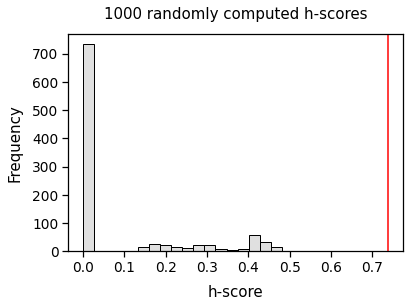

In [15]:
with sns.plotting_context("notebook", font_scale=1.25):
    fig, ax = plt.subplots()
    sns.histplot(list(df_comm_hscore.h_score), color = "lightgrey", alpha=0.7, bins = 20)
    ax.ticklabel_format(axis='x', style='scientific')
    #ax.set_xticks(np.arange(0,90))
    #ax.set_yticks(np.arange(0,200,50))
    ax.set_xlabel("h-score", labelpad=10)
    ax.set_ylabel("Frequency", labelpad=10)
    ax.set_title("1000 randomly computed h-scores", pad=15)
    plt.axvline(0.737, c= "red")
    plt.savefig("Histogram_of_hscores.svg", dpi = 300, bbox_inches = 'tight',  transparent=True)

From this results, it seems that the result of $h-value = 0.737$ is extremely unlikely to be obtained by chance.

In [150]:
list(df_comm_hscore.num_of_comm).count(36)

51

## 4 Testing the significance of our h-value 

To test the significance of our h-value of 0.737, we are going to perform a statistical test by comparing it to the h-values obtained when selecting the top 10 ranked genes from the randoly labeled dataframes.

In [167]:
## just testing KS test, not sure this is right. 
from scipy.stats import ks_2samp
ground_truth = 0.737
random_distribution = list(df_comm_hscore.num_of_comm)
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(random_distribution, [ground_truth])

# Print the p-value
print("p-value:", p_value)

p-value: 0.0019980019980020414


In [168]:
0.001 < 0.05

True